In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

# train test split
from sklearn.model_selection import train_test_split

# impute missing values
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# encoding
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from category_encoders import OrdinalEncoder, BinaryEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# cross validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

# algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, GradientBoostingClassifier

# metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, fbeta_score

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# resampling
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import normaltest

import lime
import warnings
warnings.filterwarnings('ignore')

# **1. Business Problems**

## **1.1. Problem Statement**

In the competitive telecommunication industry, customer churn happens all the time with a costly effects, with its cost 5-7 times higher than retaining the existing ones. With multiple competitors in the industry offering similar services, customer can easily switch providers for better pricing, more flexible contracts, or better service quality. As a result, telcos always face the constant threat of losing customers if they had missteps in handling their customers in their prices, poor customer service, technical issues or inadequate offerings. High churn rates can reduce profits and the customers' trust in the company, making it critical for companies to adopt a retention management strategy to protect their customers from jumping to another boat.

This project's machine learning model is aiming to help in predicting the likelihood which customers that will churn off from our services. Providing targeted retention management strategies and corners to be improved in the products.


## **1.2. Stakeholder Targets**
1. **Marketing Team**: The marketing team can use the model to identify potential customer churning and develop targeted marketing campaigns to retain them.
2. **Product Development Team**: The product development team could use the model to identify which features that could cause customers to churn and fix it.
3. **Executive Leadership**:  The higher-ups could use this model to create decisions based on data and ensure profitability and face competition from other companies in the telecommunication market.
4. **Customer Service Team**: Customer Service team could improve on the existing services that affects on the probability of customer churning.

## **1.3. Goals**
1. Create a model that can predict if a customer going to churn, applying retention strategy on customers predicted to churn.
2. Prepare retention strategies for predicted to churn customers.
3. See the importances for every features in the model, for future product development.


## **1.4. Metrics and Costs**
From the machine learning models, we need to create a prediction in which we could predict the churn of a telco customer.

- 0 => customer who is not churning
- 1 => customer who is churning

False prediction types:
- False Positive: Customer is predicted to churn, but in reality, they did not churn. Causing losses from the retention strategies employed to already loyal customers. 
- False Negative: Customer is not predicted to churn but in reality, they did churn. Causing losses due to company needing to do customer acquisition, leading to its cost.

As the median of MonthlyCharges to one customer is $70.60.

The Customer acquisition cost is $694 per customer. <a>https://userpilot.com/blog/average-customer-acquisition-cost/</a>

From another article, it is said that searching for new customers can be 5-7 times more expensive than retaining it. <a>https://www.forbes.com/councils/forbesbusinesscouncil/2022/12/12/customer-retention-versus-customer-acquisition/</a>

So we can create a **False Negative loss cost** from the customer acquisition cost and median of Monthly Charges = **($694 + $70.60) = $784.60 per customer**

Meanwhile if we get a false Positive, we would also get loss as we provides fund for promotions or extra services to people who are already loyal to us. We could use the calculation from customer acquisition cost as the **false positive loss**, providing fund to retain customer eventhough they are loyal= **($694 / 5) = $138.8 per customer**.

However for false positive loss, in the future, customer that got falsely targeted for retention strategy, will might become more loyal in the future, helping on pressing the customer churn in the future.


Hence, from the metrics shown, it is wise to use the f2 score. f2 score is a metric to evaluate a classification model that is employed when a model has a false negative cost outweighing the false positive cost, in this case, the false negative cost or the cost acquisition cost is 5x higher than its false positive or the retaining cost of a customer. The model weighs the false negatives (recall score) twice as the false positives (precision score). So that it reduces the False Negative while not forgetting about the False Positives.

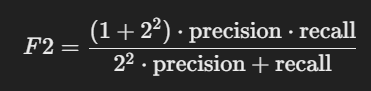

# **2.1. Data Cleaning & Preprocessing**


### Data Features: 
-	Dependents: Whether the customer has dependents or not.
-	Tenure: Number of months the customer has stayed with the company.
-	OnlineSecurity: Whether the customer has online security or not.
-	OnlineBackup: Whether the customer has online backup or not.
-	InternetService: Whether the client is subscribed to Internet service.
-	DeviceProtection: Whether the client has device protection or not.
-	TechSupport: Whether the client has tech support or not 
-	Contract: Type of contract according to duration.
-	PaperlessBilling: Bills issued in paperless form.
-	MonthlyCharges: Amount of charge for service on monthly bases.
-	Churn: Whether the customer churns or not.


In [2]:
df = pd.read_csv("data_telco_customer_churn.csv")
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


In [3]:
df.shape

(4930, 11)

In [4]:
df.duplicated().sum()

77

In [5]:
df.drop_duplicates(inplace= True)
df.duplicated().sum()

0

We drop all of the duplicates in the data as it could bother with the machine learning's model.

In [6]:
pd.DataFrame({
    'Columns' : df.columns,
    'Type' : [df[i].dtype for i in df.columns],
    'NA values' : [df[i].isna().sum() for i in df.columns],
    'nunique' : [df[i].nunique() for i in df.columns],
    'unique value' : [df[i].unique() for i in df.columns]
})

,Columns,Type,NA values,nunique,unique value
0,Dependents,object,0,2,"[Yes, No]"
1,tenure,int64,0,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1..."
2,OnlineSecurity,object,0,3,"[No, Yes, No internet service]"
3,OnlineBackup,object,0,3,"[No, Yes, No internet service]"
4,InternetService,object,0,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,object,0,3,"[Yes, No internet service, No]"
6,TechSupport,object,0,3,"[Yes, No, No internet service]"
7,Contract,object,0,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,object,0,2,"[Yes, No]"
9,MonthlyCharges,float64,0,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7,..."


The data had no NA value. So we could proceed on the EDA.

Most of the categorical types of the data in this data mostly has 2 or 3 unique values, which are mostly binary yes or no. Only contract and internet service are having their own categories.

# **2.2. EDA**

In [7]:
df.describe()

,tenure,MonthlyCharges
count,4853.000000,4853.000000
mean,32.679992,65.321543
std,24.395554,29.783655
min,0.000000,18.800000
25%,9.000000,40.050000
50%,29.000000,70.600000
75%,56.000000,90.050000
max,72.000000,118.650000


<Axes: >

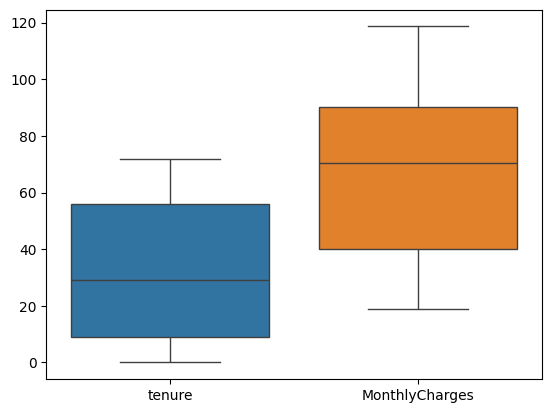

In [8]:
sns.boxplot(df)

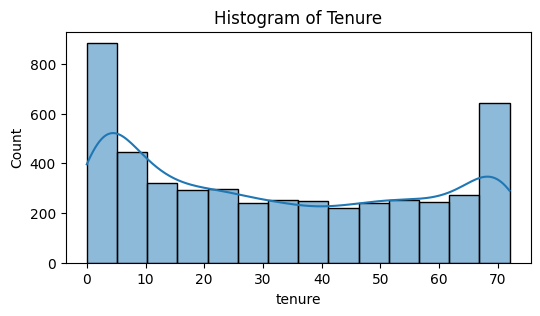

0.0 null hypothesis cannot be accepted, data is not normally distributed


In [9]:
plt.figure(figsize=(6, 3))

sns.histplot(df['tenure'], kde=True)
plt.title('Histogram of Tenure')

plt.show()

stats, pvalue = normaltest(df['tenure'])
print(pvalue, 'null hypothesis cannot be accepted, data is not normally distributed')

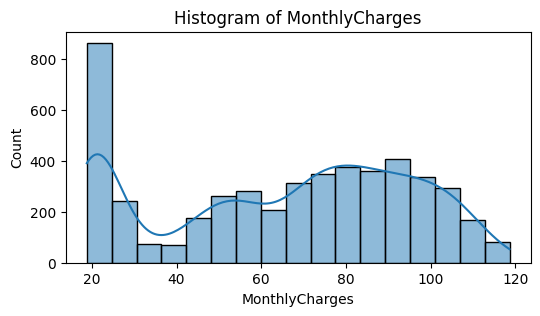

0.0 null hypothesis cannot be accepted, data is not normally distributed


In [10]:
plt.figure(figsize=(6, 3))

sns.histplot(df['MonthlyCharges'], kde=True)
plt.title('Histogram of MonthlyCharges')

plt.show()

stats, pvalue = normaltest(df['tenure'])
print(pvalue, 'null hypothesis cannot be accepted, data is not normally distributed')

There are no outliers in the data. However both the numerical data do not have normal distribution. So for the scaler, we could use MinMax scaler as StandardScaler needs a normal distribution to work.


<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

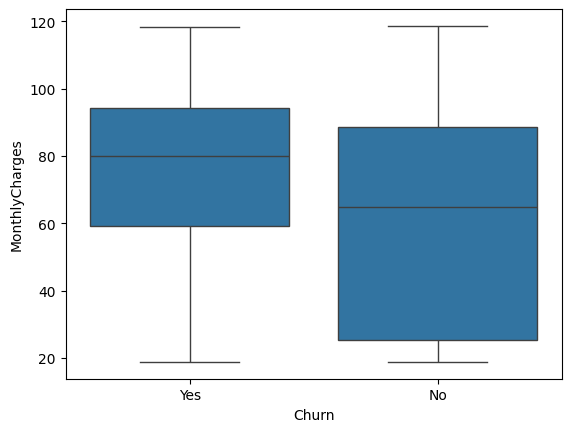

In [11]:
sns.boxplot(df, x='Churn', y= 'MonthlyCharges')

From this boxplot, we could see that most customers who had low monthly charges tended to not churn.

<Axes: xlabel='Churn', ylabel='tenure'>

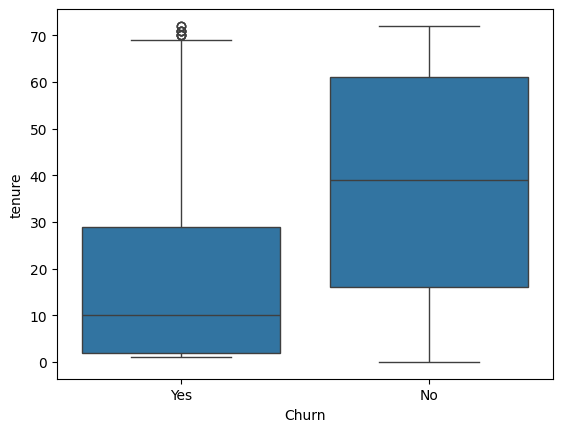

In [12]:
sns.boxplot(df, x='Churn', y= 'tenure')

From this boxplot, we could see that customers that had low tenure are most likely to churn.

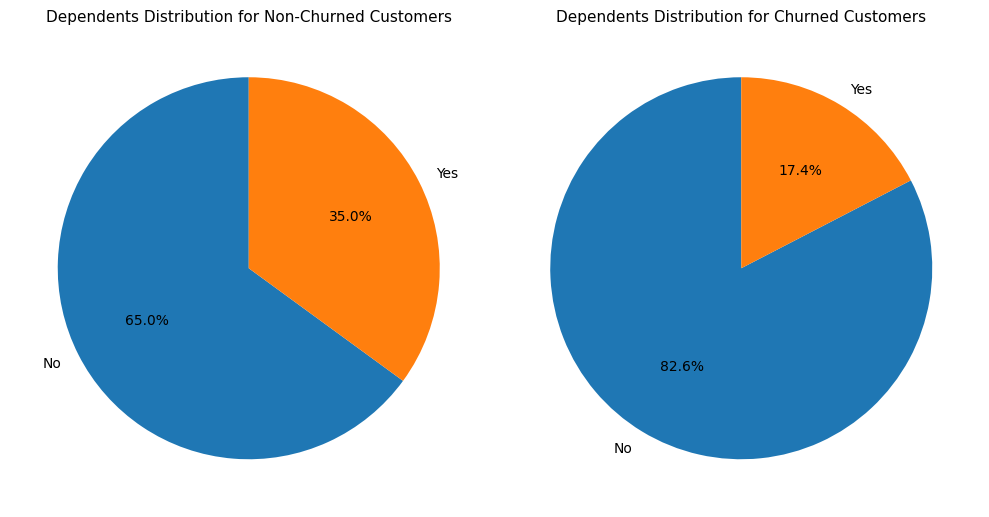

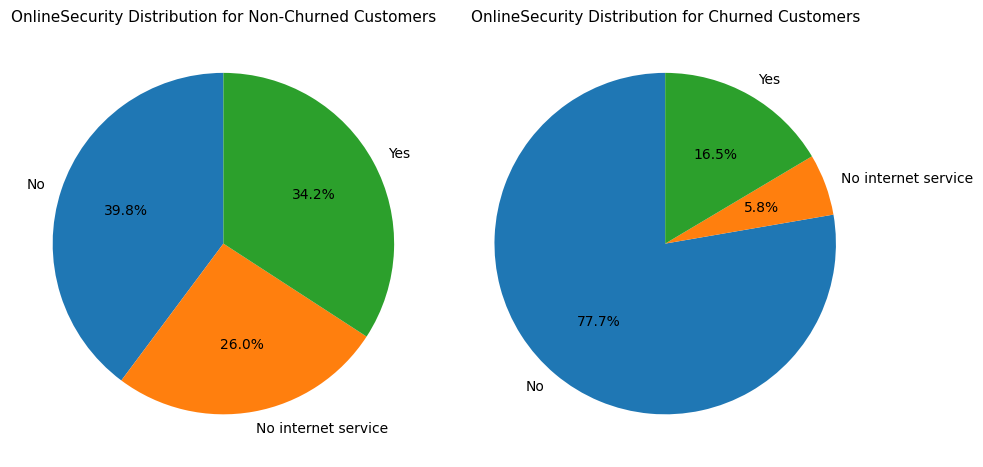

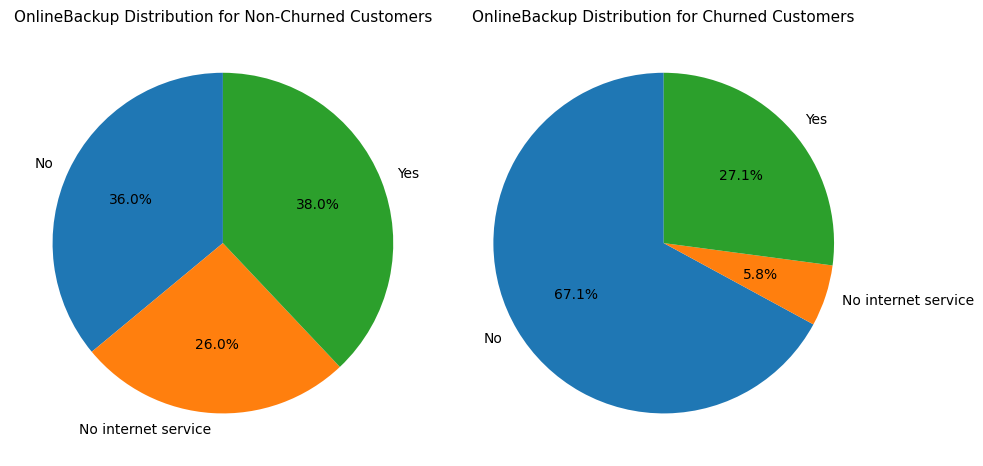

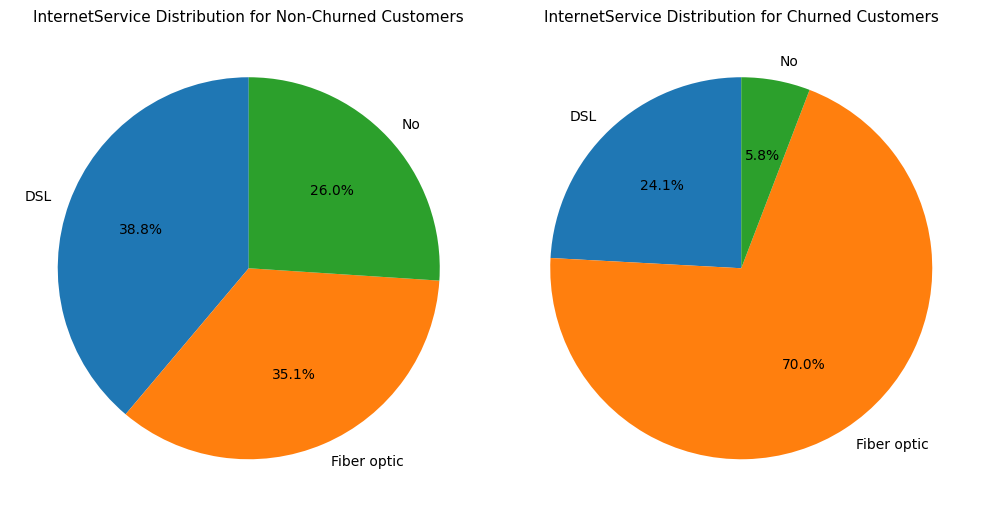

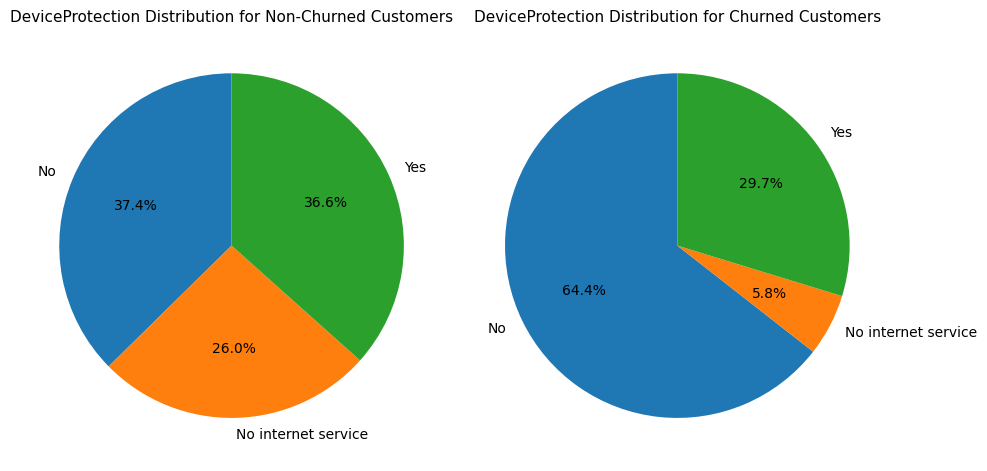

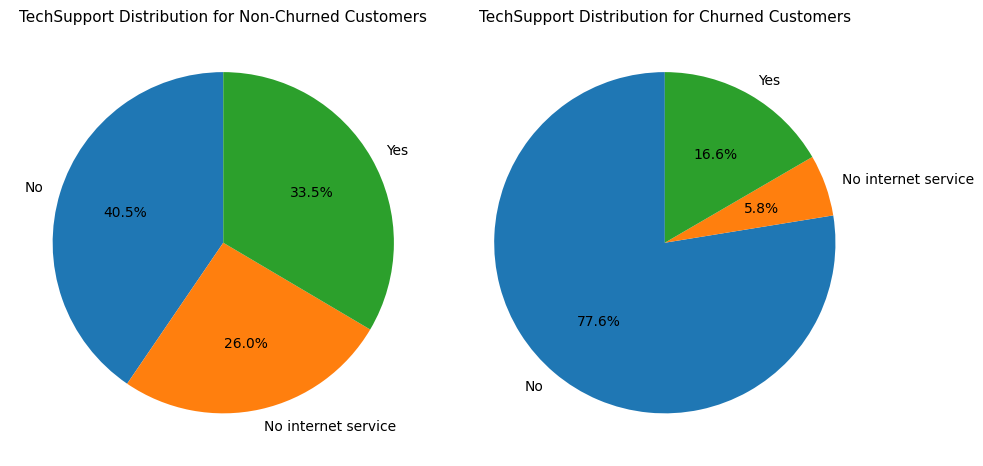

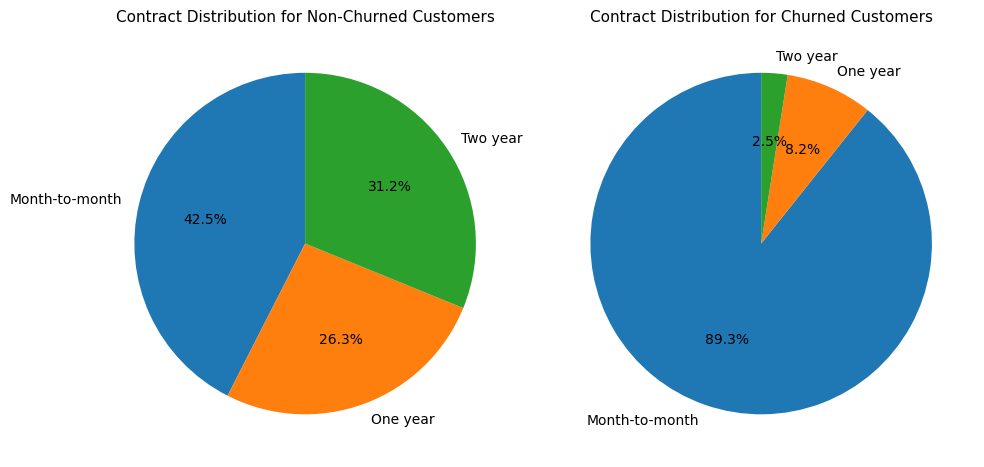

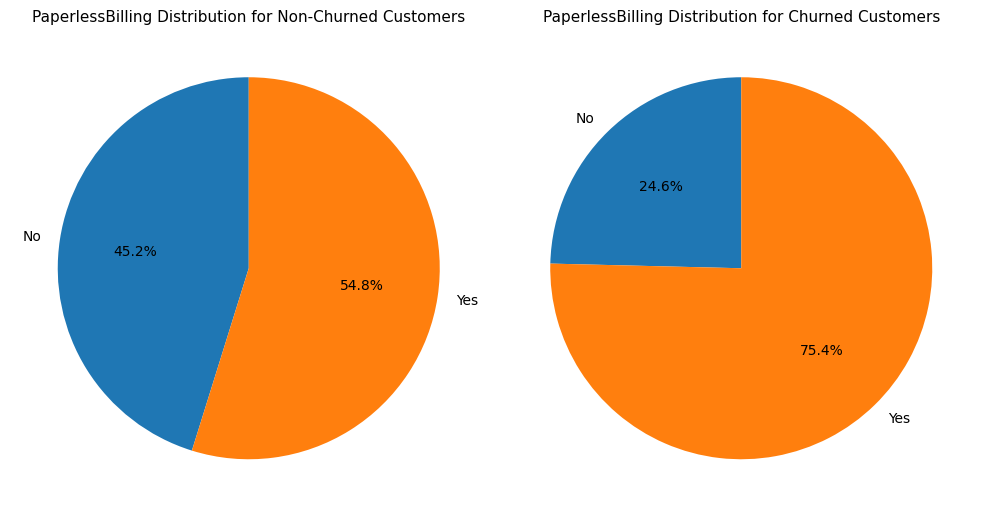

In [13]:
for i in df.drop(columns=['Churn', 'tenure', 'MonthlyCharges']).columns:
    pivot = pd.pivot_table(df, columns=i, index='Churn', values='tenure', aggfunc='count')
    pivot['Total'] = pivot.sum(axis=1)
    pivot = pivot.div(pivot['Total'], axis= 0).drop(columns= 'Total')
    pivot
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))

    ax[0].pie(pivot.iloc[0], 
            autopct='%1.1f%%', 
            startangle=90, 
            labels=pivot.columns)
    ax[0].set_title(f"{i} Distribution for Non-Churned Customers", fontsize = 11)
    ax[0].set_ylabel('')

    ax[1].pie(pivot.iloc[1], 
            autopct='%1.1f%%', 
            startangle=90, 
            labels=pivot.columns)
    ax[1].set_title(f"{i} Distribution for Churned Customers", fontsize = 11)
    ax[1].set_ylabel('')

    plt.tight_layout()

    plt.show()

- 89.3% of the churned are using Month-to-Month Contract.
- Interestingly, 70% customers that used Fiber Optic churned.


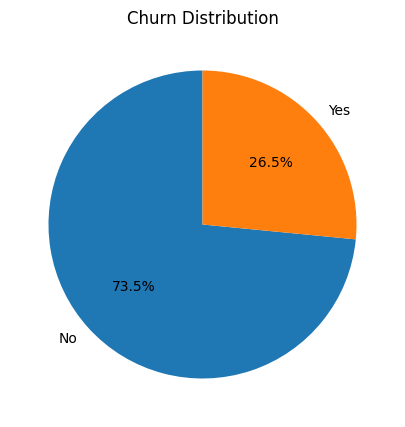

In [14]:
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(8, 5))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Churn Distribution')
plt.show()


From the data, we could see that it is imbalanced with 73.5% of the data is not churn and the 26.5% rest is churn. Later, we should use imbalance treatment or train data resampling so there will be no overfitting in the not churn category or the major category.

<Axes: xlabel='InternetService', ylabel='MonthlyCharges'>

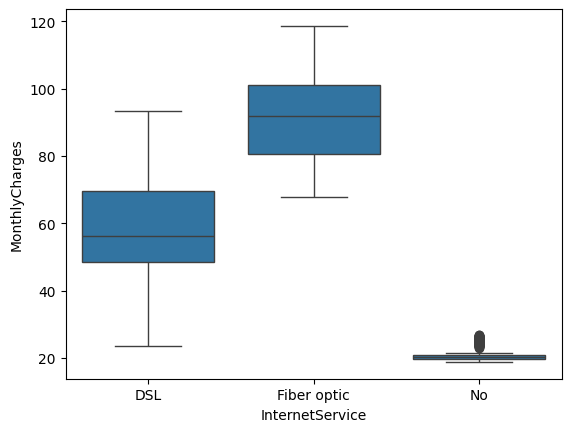

In [15]:
sns.boxplot(df, x= 'InternetService', y= 'MonthlyCharges')

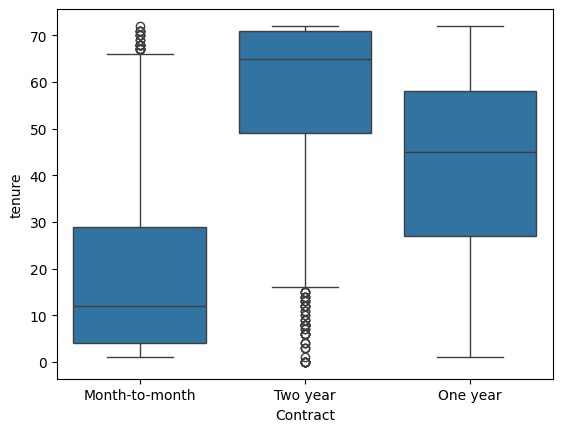

In [16]:
sns.boxplot(df, x= 'Contract', y= 'tenure')
plt.show()

- InternetServices had higher prices for every faster packages, DSL had higher price than no internet service and Fiber Optic had higher price than DSL.
- As we could see the contract had positive relationship with tenure, which scaled from lowest, Month-to-Month, One year, and two year.

*****************

## **2.3. Feature Preprocessing**

In [17]:
df['MonthlyCharges'].median()

70.6

In [18]:
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


In [19]:
df['Churn'] = np.where(df['Churn'] == 'Yes', 1, 0)

In [20]:
# Defining X and y
X = df.drop(columns='Churn')
y = df['Churn']

In [21]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 0, stratify= y)

train data already has the same proportion of churn and not churn. However, the data is imbalanced, so we may need to balance it by doing a resampling in the train data later.

Data Features preprocessing: 
-	Dependents: OneHot encoder
-	Tenure: MinMaxScaler
-	OnlineSecurity: OneHot encoder
-	OnlineBackup: OneHot encoder
-	InternetService: ordinal encoding (no : 0, DSL : 1, fiber : 2)
-	DeviceProtection: OneHot encoder
-	TechSupport: OneHot encoder
-	Contract: ordinal encoder(MtM : 1, 1 year : 2, 2 year: 3)
-	PaperlessBilling: OneHot encoder
-	MonthlyCharges: MinMaxScaler
-	Churn: change into 1 and 0

In [22]:
X_train

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges
3788,No,67,Yes,Yes,DSL,No,Yes,Two year,Yes,50.95
3348,Yes,71,Yes,Yes,DSL,Yes,Yes,Two year,No,85.45
2399,No,15,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,26.35
261,No,31,Yes,No,Fiber optic,No,No,Month-to-month,No,89.45
107,No,36,No,No,Fiber optic,No,No,Month-to-month,Yes,84.10
...,...,...,...,...,...,...,...,...,...,...
3401,No,42,No internet service,No internet service,No,No internet service,No internet service,One year,No,19.80
2397,No,18,No,Yes,DSL,No,No,Month-to-month,Yes,49.85
4469,No,6,Yes,Yes,DSL,No,No,Month-to-month,No,55.15
1532,Yes,5,No,Yes,Fiber optic,No,No,Month-to-month,Yes,80.15


In [23]:
mapping1 = [{'col': 'InternetService', 'mapping': {'No': 0, 'DSL': 1, 'Fiber optic': 2}}]
mapping2 = [{'col': 'Contract', 'mapping': {'Month-to-month': 1, 'One year': 2, 'Two year': 3}}]


transformer = ColumnTransformer([
    ('scaling', MinMaxScaler(), ['tenure', 'MonthlyCharges']),
    ('onehot', OneHotEncoder(drop= 'if_binary'), ['Dependents', 'PaperlessBilling', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'OnlineBackup']),
    ('ordinal1', OrdinalEncoder(mapping= mapping1), ['InternetService']),
    ('ordinal2', OrdinalEncoder(mapping= mapping2), ['Contract'])
], remainder= 'passthrough')
transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaling', MinMaxScaler(),
                                 ['tenure', 'MonthlyCharges']),
                                ('onehot', OneHotEncoder(drop='if_binary'),
                                 ['Dependents', 'PaperlessBilling',
                                  'OnlineSecurity', 'DeviceProtection',
                                  'TechSupport', 'OnlineBackup']),
                                ('ordinal1',
                                 OrdinalEncoder(mapping=[{'col': 'InternetService',
                                                          'data_type': dtype('O'),
                                                          'mapping': No             0
DSL            1
Fiber optic    2
dtype: int64}]),
                                 ['InternetService']),
                                ('ordinal2',
                                 OrdinalEncoder(mapping=[{'col': 'Contract',
                                                          'data_type': dtype('O'),
                                                          'mapping': Month-to-month    1
One year          2
Two year          3
dtype: int64}]),
                                 ['Contract'])])

We use MinMax scaler for the numerical columns as they do not have any outliers.

For Internet Services column, I used an ordinal encoding as Fiber optic(2) is faster than DSL(1), then no internet service will be labeled 0.

For the contract column, I also used ordinal encoding as Month-to-month is the lowest tier package with the label 1, then 1 year with the label 2 and 2 year with the label 3.

The rest of the columns will be using OneHot encoding

In [70]:
X_train_transformed = pd.DataFrame(transformer.transform(X_train), columns= transformer.get_feature_names_out())
print(X_train_transformed.shape)
X_train_transformed
df_transformed = X_train_transformed.copy()
df_transformed

(3882, 18)


,scaling__tenure,scaling__MonthlyCharges,onehot__Dependents_Yes,onehot__PaperlessBilling_Yes,onehot__OnlineSecurity_No,onehot__OnlineSecurity_No internet service,onehot__OnlineSecurity_Yes,onehot__DeviceProtection_No,onehot__DeviceProtection_No internet service,onehot__DeviceProtection_Yes,onehot__TechSupport_No,onehot__TechSupport_No internet service,onehot__TechSupport_Yes,onehot__OnlineBackup_No,onehot__OnlineBackup_No internet service,onehot__OnlineBackup_Yes,ordinal1__InternetService,ordinal2__Contract
0,0.930556,0.321983,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0
1,0.986111,0.667501,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0
2,0.208333,0.075613,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.430556,0.707561,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
4,0.500000,0.653981,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3877,0.583333,0.010015,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0
3878,0.250000,0.310966,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3879,0.083333,0.364046,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3880,0.069444,0.614422,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0


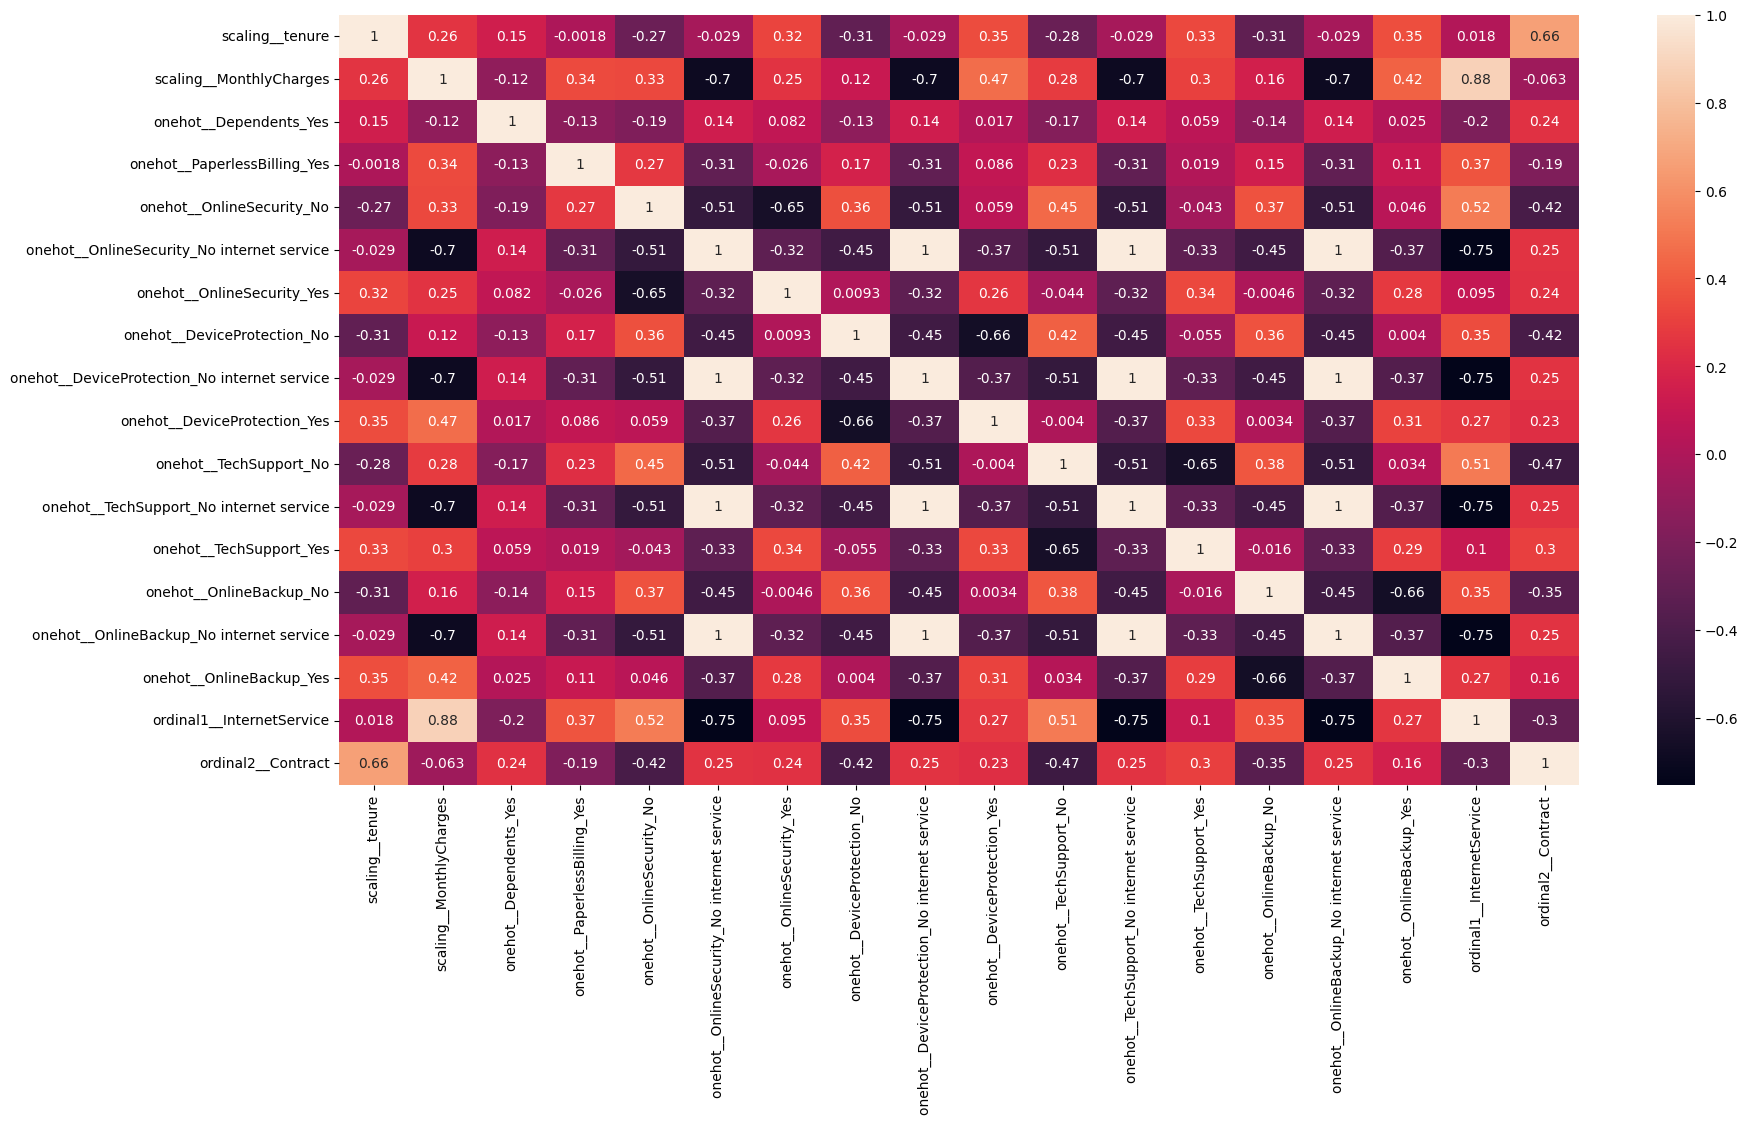

In [71]:
plt.figure(figsize= (20,10))
sns.heatmap(df_transformed.corr(method= 'spearman'), annot= True)
plt.show()

# **3. Machine Learning Model Creation**

## **3.1. Models Cross Validation**

In [26]:
# creating the scorer for gridsearch and cross validate
f2_scorer = make_scorer(fbeta_score, beta = 2)

# creating the score for usual use
def f2_score(y_true, y_pred):
    return fbeta_score(y_true= y_true, y_pred= y_pred, beta= 2)

In [27]:
logreg = LogisticRegression(random_state= 0)

tree = DecisionTreeClassifier(random_state= 0)

knn = KNeighborsClassifier(n_neighbors= 3)

forest = RandomForestClassifier(n_estimators= 100, random_state= 0)

voting = VotingClassifier(estimators = [('clf1', logreg),
                               ('clf2', tree),
                               ('clf3', knn)])

stacking = StackingClassifier(estimators = [('clf1', logreg),
                                 ('clf2', tree),
                                 ('clf3', knn)],
                   final_estimator= LogisticRegression())

bagging = BaggingClassifier(estimator=KNeighborsClassifier(), 
                  n_estimators=10, 
                  random_state=0)


adaboost = AdaBoostClassifier(random_state=0)

gradient = GradientBoostingClassifier(random_state= 0)

xgb = XGBClassifier()

list_model = [logreg, tree, knn, forest, voting, stacking, bagging, adaboost, gradient, xgb]

In [28]:
list_score = []
list_mean = []
list_std = []

for model in list_model:
    pipe_prep_model = Pipeline([
        ('preprocessing', transformer),
        ('rebalancing', SMOTE()),
        ('modeling', model)
    ])
    
    cv_score = cross_val_score(
        estimator = pipe_prep_model,
        cv = 5,
        scoring = f2_scorer,
        X = X_train,
        y = y_train,
        n_jobs=-1
    )
    
    list_score.append(cv_score.round(2))
    list_mean.append(cv_score.mean())
    list_std.append(cv_score.std())

In [29]:
pd.DataFrame({
    'model' : list_model,
    'all_score' : list_score,
    'mean_score' : list_mean,
    'std_score' : list_std
}).sort_values(by= 'mean_score', ascending= False)

,model,all_score,mean_score,std_score
7,AdaBoostClassifier(random_state=0),"[0.69, 0.73, 0.7, 0.73, 0.72]",0.714413,0.015882
8,GradientBoostingClassifier(random_state=0),"[0.68, 0.72, 0.68, 0.73, 0.71]",0.703648,0.020624
0,LogisticRegression(random_state=0),"[0.68, 0.72, 0.7, 0.7, 0.73]",0.703276,0.017999
9,"XGBClassifier(base_score=None, booster=None, c...","[0.64, 0.63, 0.62, 0.65, 0.67]",0.640572,0.018523
4,"VotingClassifier(estimators=[('clf1', Logistic...","[0.63, 0.64, 0.63, 0.62, 0.68]",0.638681,0.019032
6,BaggingClassifier(estimator=KNeighborsClassifi...,"[0.65, 0.62, 0.62, 0.62, 0.63]",0.624460,0.011041
5,"StackingClassifier(estimators=[('clf1', Logist...","[0.64, 0.61, 0.6, 0.61, 0.62]",0.616217,0.012308
2,KNeighborsClassifier(n_neighbors=3),"[0.62, 0.58, 0.59, 0.6, 0.6]",0.597123,0.011470
3,RandomForestClassifier(random_state=0),"[0.6, 0.56, 0.62, 0.59, 0.57]",0.588460,0.021564
1,DecisionTreeClassifier(random_state=0),"[0.57, 0.57, 0.54, 0.56, 0.54]",0.556442,0.012554


We take the top 3 model that has the closest accuracy and the highest and test for its test accuracy, which are AdaBoostClassifier, LogisticRegression, and GradientBoosting.

***********

## **3.2. Hyperparameter Tuning and Resampling the Top Models**

In [30]:
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)
nm = NearMiss(sampling_strategy='majority')
smote = SMOTE()


list_resampler = [None, ros, rus, nm, smote]

### **3.2.1. Logistic Regression**

### Hyperparameter Tuning

In [31]:
# logreg
model = logreg
pipe_prep_model = Pipeline([
    ('resampling', None),
    ('preprocessing', transformer),
    ('modeling', model)
])

hyperparam = {
              'resampling' : [None, ros, rus, nm, smote],
              'modeling__C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
              'modeling__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'modeling__multi_class' : ['auto', 'ovr', 'multinomial'],
              'modeling__class_weight' : [None, 'balanced']}

skf = StratifiedKFold(n_splits = 5)

gridsearch_logreg = GridSearchCV(
    estimator= pipe_prep_model,
    param_grid= hyperparam,
    scoring = f2_scorer,
    n_jobs = -1,
    cv = skf
)
gridsearch_logreg

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('resampling', None),
                                       ('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         MinMaxScaler(),
                                                                         ['tenure',
                                                                          'MonthlyCharges']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Dependents',
                                                                          'PaperlessBilling',
                                                                          'OnlineSecurity',
                                                                          'DeviceP...
                         'modeling__class_weight': [None, 'balanced'],
                         'modeling__multi_class': ['auto', 'ovr',
                                                   'multinomial'],
                         'modeling__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                              'newton-cholesky', 'sag',
                                              'saga'],
                         'resampling': [None, RandomOverSampler(random_state=0),
                                        RandomUnderSampler(random_state=0),
                                        NearMiss(sampling_strategy='majority'),
                                        SMOTE()]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [32]:
gridsearch_logreg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('resampling', None),
                                       ('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         MinMaxScaler(),
                                                                         ['tenure',
                                                                          'MonthlyCharges']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Dependents',
                                                                          'PaperlessBilling',
                                                                          'OnlineSecurity',
                                                                          'DeviceP...
                         'modeling__class_weight': [None, 'balanced'],
                         'modeling__multi_class': ['auto', 'ovr',
                                                   'multinomial'],
                         'modeling__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                              'newton-cholesky', 'sag',
                                              'saga'],
                         'resampling': [None, RandomOverSampler(random_state=0),
                                        RandomUnderSampler(random_state=0),
                                        NearMiss(sampling_strategy='majority'),
                                        SMOTE()]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [33]:
score_train_logreg = gridsearch_logreg.best_score_
print('best Logreg after tuning score:', score_train_logreg)

best Logreg after tuning score: 0.7245313562598978


In [34]:
# before tuning
model = logreg
pipe_prep_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', model)
])
pipe_prep_model.fit(X_train, y_train)

y_pred_before = pipe_prep_model.predict(X_test)

score_test_logreg_before = f2_score(y_test, y_pred_before)
score_test_logreg_before

0.5501618122977346

In [35]:
best_model_logreg = gridsearch_logreg.best_estimator_

# fitting
best_model_logreg.fit(X_train, y_train)

# predict
y_pred_tuning = best_model_logreg.predict(X_test)

# recall score
score_test_logreg = f2_score(y_test,y_pred_tuning)
score_test_logreg

0.7350948509485095

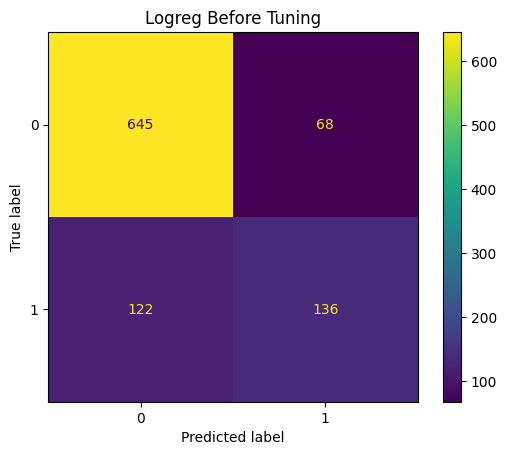

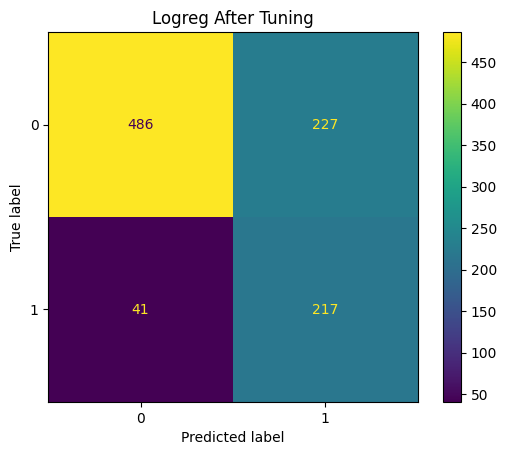

In [36]:
cm_before = confusion_matrix(y_test, y_pred_before)

# conf. after tuning
cm_after = confusion_matrix(y_test, y_pred_tuning)

# # before tuning
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
disp_before.plot()
plt.title('Logreg Before Tuning')

# after tuning
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot()
plt.title('Logreg After Tuning')

plt.show()

### Threshold Tuning

In [37]:

# Model LogReg after tuning
best_model_logreg.fit(X_train, y_train)
# ---------------------------------------
th_value = [i/100 for i in range(1,100)]
recall_score_list = []
f1_score_list = []
f2_score_list = []
FN_list = []
FP_list = []
th_list = []
precision_list = []
score = 0


for i in th_value:

    y_prob = best_model_logreg.predict_proba(X_test)[: , 1]
    y_pred = np.where(y_prob>i, 1, 0)

    recall_score_temp = recall_score(y_test, y_pred)
    precision_score_temp = precision_score(y_test, y_pred)
    f1_score_temp = f1_score(y_test, y_pred)
    f2_score_temp = f2_score(y_test, y_pred)
    FN_temp = confusion_matrix(y_test, y_pred)[1,0]
    FP_temp = confusion_matrix(y_test, y_pred)[0,1]
    th_list.append(i)
    recall_score_list.append(recall_score_temp)
    precision_list.append(precision_score_temp)
    f1_score_list.append(f1_score_temp)
    f2_score_list.append(f2_score_temp)
    FN_list.append(FN_temp)
    FP_list.append(FP_temp)

In [38]:
threshold_df_logreg = pd.DataFrame({'th-value' : th_list, 'recall score' : recall_score_list, 'precision score' : precision_list, 'f1 score' : f1_score_list, 'f2 score' : f2_score_list, 'FN' : FN_list, 'FP' : FP_list})
threshold_df_logreg.sort_values(by = 'f2 score', ascending = False)

,th-value,recall score,precision score,f1 score,f2 score,FN,FP
47,0.48,0.906977,0.435754,0.588679,0.745698,24,303
48,0.49,0.875969,0.455645,0.599469,0.739529,32,270
49,0.50,0.841085,0.488739,0.618234,0.735095,41,227
46,0.47,0.910853,0.404475,0.560191,0.728456,23,346
44,0.45,0.984496,0.356742,0.523711,0.728211,4,458
...,...,...,...,...,...,...,...
71,0.72,0.000000,0.000000,0.000000,0.000000,258,0
72,0.73,0.000000,0.000000,0.000000,0.000000,258,0
73,0.74,0.000000,0.000000,0.000000,0.000000,258,0
74,0.75,0.000000,0.000000,0.000000,0.000000,258,0


f2 score: 0.745697896749522
recall score: 0.9069767441860465
Ensemble Model Report:
               precision    recall  f1-score   support

           0       0.94      0.58      0.71       713
           1       0.44      0.91      0.59       258

    accuracy                           0.66       971
   macro avg       0.69      0.74      0.65       971
weighted avg       0.81      0.66      0.68       971



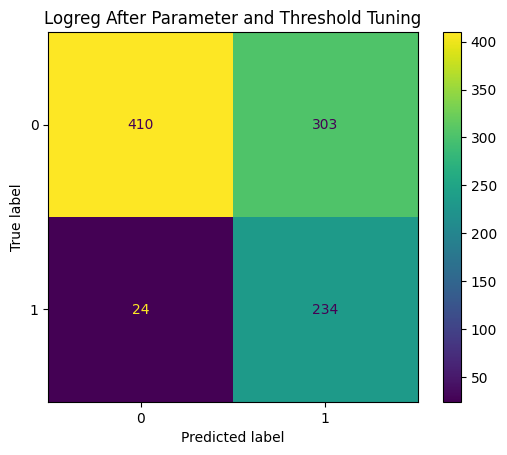

In [39]:
# fitting
best_model_logreg.fit(X_train, y_train)

# predict
y_pred_tuning = best_model_logreg.predict_proba(X_test)[: , 1]
y_pred_tuning = np.where(y_pred_tuning > 0.48, 1, 0)

# f2 score
print('f2 score:', f2_score(y_test, y_pred_tuning))
print('recall score:', recall_score(y_test, y_pred_tuning))

# conf. after tuning
cm_after = confusion_matrix(y_test, y_pred_tuning)

print("Ensemble Model Report:\n", classification_report(y_test, y_pred_tuning))

# after tuning
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot()
plt.title('Logreg After Parameter and Threshold Tuning')

plt.show()

### **3.2.2. Gradient Model**

### Hyperparameter Tuning

In [40]:
model = gradient
pipe_prep_model = Pipeline([
    ('resampling', None),
    ('preprocessing', transformer),
    ('modeling', model)
])

hyperparam = {
              'resampling' : [None, ros, rus, nm, smote],
              'modeling__n_estimators' : range(100,301,50),
              'modeling__learning_rate' : np.arange(0.1,1.1,0.1),
              'modeling__min_samples_split' : range(2,11,1),
              'modeling__min_samples_leaf' : range(1,11,1),
              'modeling__max_depth' : range(3,11,1)}

skf = StratifiedKFold(n_splits = 5)

randsearch_grad = RandomizedSearchCV(
    estimator= pipe_prep_model,
    param_distributions= hyperparam,
    scoring = f2_scorer,
    n_jobs = -1,
    cv = skf,
    random_state = 0,
    n_iter= 2500
)
randsearch_grad

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('resampling', None),
                                             ('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               MinMaxScaler(),
                                                                               ['tenure',
                                                                                'MonthlyCharges']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='if_binary'),
                                                                               ['Dependents',
                                                                                'PaperlessBilling',
                                                                                'OnlineSecurity',
                                                                                'D...
                                        'modeling__max_depth': range(3, 11),
                                        'modeling__min_samples_leaf': range(1, 11),
                                        'modeling__min_samples_split': range(2, 11),
                                        'modeling__n_estimators': range(100, 301, 50),
                                        'resampling': [None,
                                                       RandomOverSampler(random_state=0),
                                                       RandomUnderSampler(random_state=0),
                                                       NearMiss(sampling_strategy='majority'),
                                                       SMOTE()]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [41]:
randsearch_grad.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('resampling', None),
                                             ('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               MinMaxScaler(),
                                                                               ['tenure',
                                                                                'MonthlyCharges']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='if_binary'),
                                                                               ['Dependents',
                                                                                'PaperlessBilling',
                                                                                'OnlineSecurity',
                                                                                'D...
                                        'modeling__max_depth': range(3, 11),
                                        'modeling__min_samples_leaf': range(1, 11),
                                        'modeling__min_samples_split': range(2, 11),
                                        'modeling__n_estimators': range(100, 301, 50),
                                        'resampling': [None,
                                                       RandomOverSampler(random_state=0),
                                                       RandomUnderSampler(random_state=0),
                                                       NearMiss(sampling_strategy='majority'),
                                                       SMOTE()]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [42]:
randsearch_grad.best_score_

0.7123105220987428

In [43]:
model = gradient
pipe_prep_model = Pipeline([
    ('resampling', None),
    ('preprocessing', transformer),
    ('modeling', model)
])
y_pred_before = pipe_prep_model.fit(X_train, y_train).predict(X_test)
print('f2 score: ', f2_score(y_test, y_pred_before))
print(classification_report(y_test, y_pred_before))

f2 score:  0.5179445350734094
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       713
           1       0.65      0.49      0.56       258

    accuracy                           0.80       971
   macro avg       0.74      0.70      0.71       971
weighted avg       0.78      0.80      0.79       971



In [44]:
best_model_grad = randsearch_grad.best_estimator_
best_model_grad.fit(X_train, y_train)
y_pred_tuning = best_model_grad.predict(X_test)
print('f2 score: ', f2_score(y_test, y_pred_tuning))
print(classification_report(y_test, y_pred_tuning))

f2 score:  0.712280701754386
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       713
           1       0.52      0.79      0.62       258

    accuracy                           0.75       971
   macro avg       0.71      0.76      0.72       971
weighted avg       0.80      0.75      0.76       971



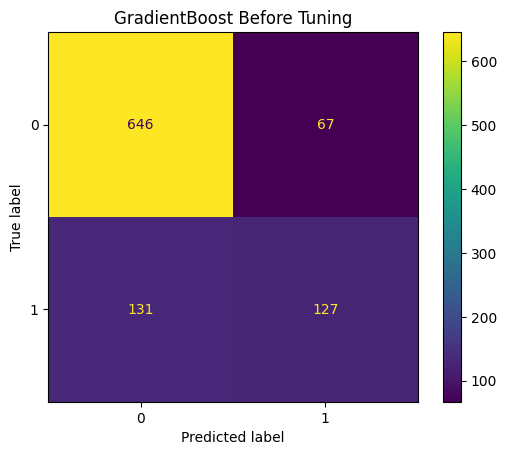

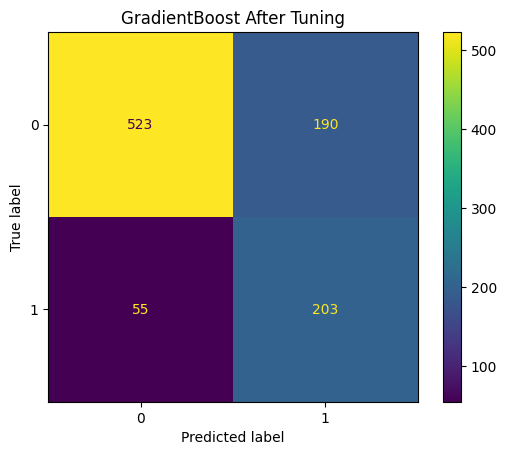

In [45]:
cm_before = confusion_matrix(y_test, y_pred_before)

# conf. after tuning
cm_after = confusion_matrix(y_test, y_pred_tuning)

# # before tuning
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
disp_before.plot()
plt.title('GradientBoost Before Tuning')

# after tuning
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot()
plt.title('GradientBoost After Tuning')

plt.show()

### Threshold Tuning

In [46]:

# Model GradientBoost after tuning
best_model_grad.fit(X_train, y_train)
# ---------------------------------------
th_value = [i/100 for i in range(1,100)]
recall_score_list = []
f1_score_list = []
f2_score_list = []
FN_list = []
FP_list = []
th_list = []
precision_list = []
score = 0


for i in th_value:

    # predict
    y_prob = best_model_grad.predict_proba(X_test)[: , 1]
    y_pred = np.where(y_prob>i, 1, 0)

    recall_score_temp = recall_score(y_test, y_pred)
    precision_score_temp = precision_score(y_test, y_pred)
    f1_score_temp = f1_score(y_test, y_pred)
    f2_score_temp = f2_score(y_test, y_pred)
    FN_temp = confusion_matrix(y_test, y_pred)[1,0]
    FP_temp = confusion_matrix(y_test, y_pred)[0,1]
    th_list.append(i)
    recall_score_list.append(recall_score_temp)
    precision_list.append(precision_score_temp)
    f1_score_list.append(f1_score_temp)
    f2_score_list.append(f2_score_temp)
    FN_list.append(FN_temp)
    FP_list.append(FP_temp)

threshold_df_grad = pd.DataFrame({'th-value' : th_list, 'recall score' : recall_score_list, 'precision score' : precision_list, 'f1 score' : f1_score_list, 'f2 score' : f2_score_list, 'FN' : FN_list, 'FP' : FP_list})
threshold_df_grad.sort_values(by = 'f2 score', ascending = False)

,th-value,recall score,precision score,f1 score,f2 score,FN,FP
35,0.36,0.891473,0.467480,0.613333,0.754593,28,262
33,0.34,0.895349,0.462000,0.609499,0.753916,27,269
34,0.35,0.891473,0.465587,0.611702,0.753604,28,264
36,0.37,0.883721,0.473029,0.616216,0.752972,30,254
31,0.32,0.899225,0.454902,0.604167,0.752270,26,278
...,...,...,...,...,...,...,...
94,0.95,0.011628,1.000000,0.022989,0.014493,255,0
95,0.96,0.000000,0.000000,0.000000,0.000000,258,0
96,0.97,0.000000,0.000000,0.000000,0.000000,258,0
97,0.98,0.000000,0.000000,0.000000,0.000000,258,0


f2 score: 0.7455012853470437
recall score: 0.8992248062015504
Ensemble Model Report:
               precision    recall  f1-score   support

           0       0.94      0.59      0.73       713
           1       0.44      0.90      0.59       258

    accuracy                           0.67       971
   macro avg       0.69      0.74      0.66       971
weighted avg       0.81      0.67      0.69       971



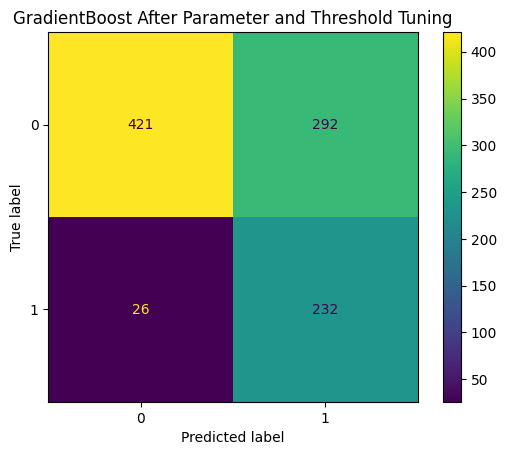

In [47]:
# fitting
best_model_grad.fit(X_train, y_train)

# predict
y_pred_tuning = best_model_grad.predict_proba(X_test)[: , 1]
y_pred_tuning = np.where(y_pred_tuning > 0.29, 1, 0)

# recall score
print('f2 score:', f2_score(y_test, y_pred_tuning))
print('recall score:', recall_score(y_test, y_pred_tuning))

# conf. after tuning
cm_after = confusion_matrix(y_test, y_pred_tuning)

print("Ensemble Model Report:\n", classification_report(y_test, y_pred_tuning))


# after tuning
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot()
plt.title('GradientBoost After Parameter and Threshold Tuning')

plt.show()

### **3.2.3. ADABoost**

### Hyperparameter Tuning

In [48]:
model = AdaBoostClassifier(random_state= 0)

pipe_prep_model = Pipeline([
    ('resampling', None),
    ('preprocessing', transformer),
    ('modeling', model)
])

hyperparam = {
              'resampling' : [None, ros, rus, nm, smote],
              'modeling__n_estimators' : range(30,201,10),
              'modeling__learning_rate' :np.arange(0,1,0.1),
              'modeling__algorithm' : ['SAMME', 'SAMME.R']}

skf= StratifiedKFold(n_splits= 5)

gridsearch_ada = GridSearchCV(
    estimator= pipe_prep_model,
    param_grid= hyperparam,
    scoring = f2_scorer,
    n_jobs = -1,
    cv = skf
)
gridsearch_ada

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('resampling', None),
                                       ('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         MinMaxScaler(),
                                                                         ['tenure',
                                                                          'MonthlyCharges']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Dependents',
                                                                          'PaperlessBilling',
                                                                          'OnlineSecurity',
                                                                          'DeviceP...
             param_grid={'modeling__algorithm': ['SAMME', 'SAMME.R'],
                         'modeling__learning_rate': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'modeling__n_estimators': range(30, 201, 10),
                         'resampling': [None, RandomOverSampler(random_state=0),
                                        RandomUnderSampler(random_state=0),
                                        NearMiss(sampling_strategy='majority'),
                                        SMOTE()]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [49]:
gridsearch_ada.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('resampling', None),
                                       ('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         MinMaxScaler(),
                                                                         ['tenure',
                                                                          'MonthlyCharges']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Dependents',
                                                                          'PaperlessBilling',
                                                                          'OnlineSecurity',
                                                                          'DeviceP...
             param_grid={'modeling__algorithm': ['SAMME', 'SAMME.R'],
                         'modeling__learning_rate': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'modeling__n_estimators': range(30, 201, 10),
                         'resampling': [None, RandomOverSampler(random_state=0),
                                        RandomUnderSampler(random_state=0),
                                        NearMiss(sampling_strategy='majority'),
                                        SMOTE()]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [50]:
score_train_ada = gridsearch_ada.best_score_
print('AdaBoost train f2 score: ',score_train_ada)

AdaBoost train f2 score:  0.7355453662868634


In [51]:
# before tuning and resampling
model = adaboost
pipe_prep_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', model)
])
pipe_prep_model.fit(X_train, y_train)

y_pred_before = pipe_prep_model.predict(X_test)

score_test_ada_before = f2_score(y_test, y_pred_before)
score_test_ada_before

0.5402112103980503

In [52]:
best_model_ada = gridsearch_ada.best_estimator_

# fitting
best_model_ada.fit(X_train, y_train)

# predict
y_pred_tuning = best_model_ada.predict(X_test)

# f2 score
score_test_ada = f2_score(y_test,y_pred_tuning)
score_test_ada

0.7506613756613757

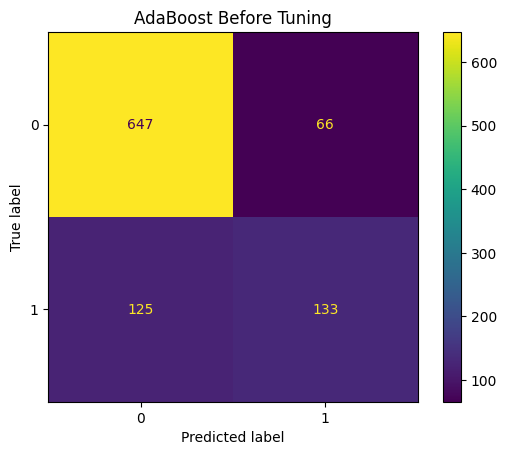

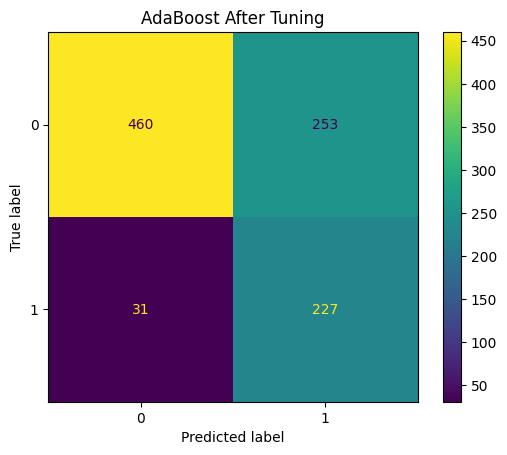

In [53]:
cm_before = confusion_matrix(y_test, y_pred_before)

# conf. after tuning
cm_after = confusion_matrix(y_test, y_pred_tuning)

# # before tuning
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
disp_before.plot()
plt.title('AdaBoost Before Tuning')

# after tuning
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot()
plt.title('AdaBoost After Tuning')

plt.show()

### Threshold Tuning

In [54]:
# Model adaboost after tuning
best_model_ada.fit(X_train, y_train)
# ---------------------------------------
th_value = [i/100 for i in range(1,100)]
recall_score_list = []
precision_list = []
f1_score_list = []
f2_score_list = []
FN_list = []
FP_list = []
th_list = []
score = 0

for i in th_value:

    # predict
    y_prob = best_model_ada.predict_proba(X_test)[: , 1]
    y_pred = np.where(y_prob>i, 1, 0)

    recall_score_temp = recall_score(y_test, y_pred)
    precision_score_temp = precision_score(y_test, y_pred)
    FN_temp = confusion_matrix(y_test, y_pred)[1,0]
    FP_temp = confusion_matrix(y_test, y_pred)[0,1]
    f1_score_list.append(f1_score(y_test, y_pred))
    f2_score_list.append(f2_score(y_test, y_pred))
    th_list.append(i)
    recall_score_list.append(recall_score_temp)
    precision_list.append(precision_score_temp)
    FN_list.append(FN_temp)
    FP_list.append(FP_temp)

In [55]:
threshold_df_ada = pd.DataFrame({'th-value' : th_list, 'recall score' : recall_score_list, 'precision score' : precision_list, 'f1 score' : f1_score_list, 'f2 score' : f2_score_list, 'FN' : FN_list, 'FP' : FP_list})
threshold_df_ada.sort_values(by = 'f2 score', ascending = False)

,th-value,recall score,precision score,f1 score,f2 score,FN,FP
48,0.49,0.903101,0.468813,0.617219,0.761936,25,264
47,0.48,0.903101,0.467871,0.616402,0.761438,25,265
55,0.56,0.860465,0.517483,0.646288,0.759754,36,207
56,0.57,0.860465,0.517483,0.646288,0.759754,36,207
46,0.47,0.910853,0.454545,0.606452,0.758554,23,282
...,...,...,...,...,...,...,...
84,0.85,0.000000,0.000000,0.000000,0.000000,258,0
83,0.84,0.000000,0.000000,0.000000,0.000000,258,0
82,0.83,0.000000,0.000000,0.000000,0.000000,258,0
81,0.82,0.000000,0.000000,0.000000,0.000000,258,0


f2 score: 0.761935905820798
recall score: 0.9031007751937985


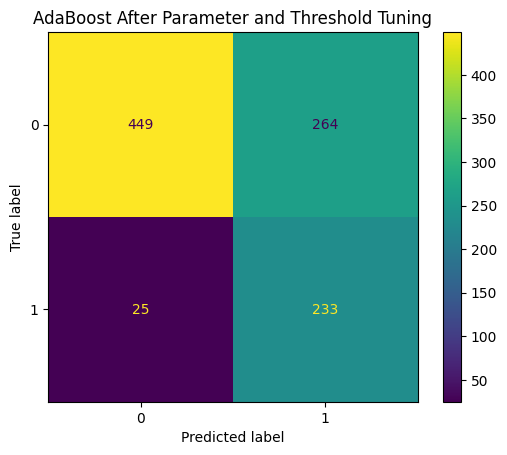

In [56]:
# fitting
best_model_ada.fit(X_train, y_train)

# predict
y_pred_tuning = best_model_ada.predict_proba(X_test)[: , 1]
y_pred_tuning = np.where(y_pred_tuning > 0.49, 1, 0)

# recall score
print('f2 score:', f2_score(y_test, y_pred_tuning))
print('recall score:', recall_score(y_test, y_pred_tuning))

# conf. after tuning
cm_after = confusion_matrix(y_test, y_pred_tuning)


# after tuning
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot()
plt.title('AdaBoost After Parameter and Threshold Tuning')

plt.show()

### **3.3.1. Best Model Selection**

In [57]:
y_pred_ada = best_model_ada.predict_proba(X_test)[:,1]
y_pred_ada = np.where(y_pred_ada > 0.49, 1, 0)
print('ADABoost after tuning:')
print(classification_report(y_test, y_pred_ada))
print('f2 score: ', f2_score(y_test, y_pred_ada))
print()

y_pred_logreg = best_model_logreg.predict_proba(X_test)[:,1]
y_pred_logreg = np.where(y_pred_logreg > 0.5, 1, 0)
print('Logreg after tuning:')
print(classification_report(y_test, y_pred_logreg))
print('f2 score: ', f2_score(y_test, y_pred_logreg))
print()

y_pred_grad = best_model_grad.predict_proba(X_test)[:,1]
y_pred_grad = np.where(y_pred_grad > 0.49, 1, 0)
print('GradBoost after tuning:')
print(classification_report(y_test, y_pred_grad))
print('f2 score: ', f2_score(y_test, y_pred_grad))

ADABoost after tuning:
              precision    recall  f1-score   support

           0       0.95      0.63      0.76       713
           1       0.47      0.90      0.62       258

    accuracy                           0.70       971
   macro avg       0.71      0.77      0.69       971
weighted avg       0.82      0.70      0.72       971

f2 score:  0.761935905820798

Logreg after tuning:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       713
           1       0.49      0.84      0.62       258

    accuracy                           0.72       971
   macro avg       0.71      0.76      0.70       971
weighted avg       0.81      0.72      0.74       971

f2 score:  0.7350948509485095

GradBoost after tuning:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81       713
           1       0.51      0.79      0.62       258

    accuracy                           0.74       971

From the parameter and threshold tuning of the models, we could see that the winner is the AdaBoost Model with the threshold set at 0.49 and the tuning of below:

In [58]:
best_model_ada

Pipeline(steps=[('resampling', RandomUnderSampler(random_state=0)),
                ('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Dependents',
                                                   'PaperlessBilling',
                                                   'OnlineSecurity',
                                                   'DeviceProtection',
                                                   'TechSupport',
                                                   'OnlineBackup']),
                                                 ('ordinal1',
                                                  Or...g=[{'col': 'InternetService',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': No             0
DSL            1
Fiber optic    2
dtype: int64}]),
                                                  ['InternetService']),
                                                 ('ordinal2',
                                                  OrdinalEncoder(mapping=[{'col': 'Contract',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': Month-to-month    1
One year          2
Two year          3
dtype: int64}]),
                                                  ['Contract'])])),
                ('modeling',
                 AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1,
                                    random_state=0))])

**AdaBoost or Adaptive Boosting** is a statistical meta algorithm invented by Yoav Freund and Robert Schapire in 1995. It is adaptive in a sense that weak learners in this model, a decision tree classifier with the max depth of 1 is tuned to instances misclassified by previous classifiers. The advantage of this model is that it could reduce bias and variance in the data. On the other hand, the disadvantage is that it could be very sensitive on outliers, giving them very high weight leading overfitting, however, in the data there is no outliers so that it is fine to use AdaBoost.

In this case of data, the AdaBoost algorithm has many decision tree classifiers, the training samples are given the same weight at first. After using 1 decision tree classifiers, then there will be correct classification of churn and not churn, and the wrong classification. The model then focus more on the wrong classification by giving them more weight for the next decision tree classifier to learn, and looping until the last weak learner.

### **3.3.2. Feature Importances**

In [59]:
feature_importances = pd.DataFrame({'features' : X_train_transformed.columns,'importance values' : best_model_ada[2].feature_importances_}).sort_values(by = 'importance values', ascending = False)
feature_importances

,features,importance values
17,ordinal2__Contract,0.609788
0,scaling__tenure,0.153734
16,ordinal1__InternetService,0.135161
4,onehot__OnlineSecurity_No,0.080014
10,onehot__TechSupport_No,0.021302
2,onehot__Dependents_Yes,0.000000
3,onehot__PaperlessBilling_Yes,0.000000
5,onehot__OnlineSecurity_No internet service,0.000000
6,onehot__OnlineSecurity_Yes,0.000000
7,onehot__DeviceProtection_No,0.000000


In [60]:
X_train_transformed = best_model_ada[0:2].transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns= best_model_ada[1].get_feature_names_out())

In [61]:
from lime import lime_tabular
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data = best_model_ada[0:2].transform(X_train),
    feature_names = best_model_ada[1].get_feature_names_out(),
    class_names = ['Not Churn', 'Churn'],
    mode= 'classification'
)
X_test_transformed = best_model_ada[1].transform(X_test)


The prediction must predict this customer is: churned from y_test


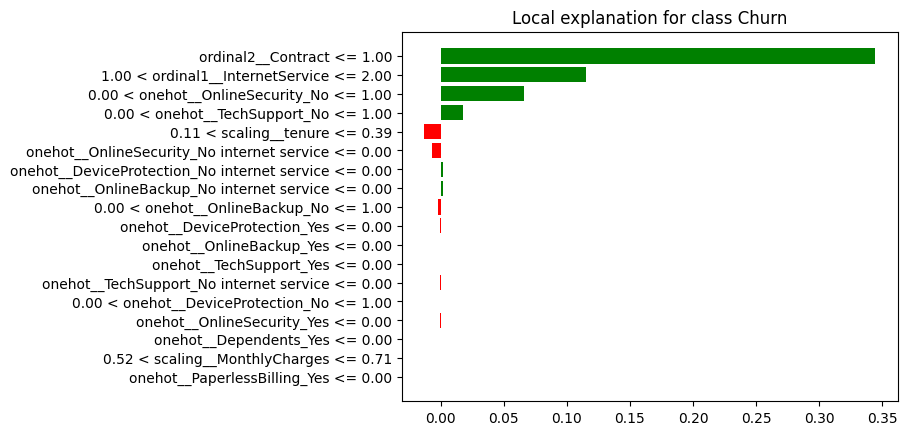

In [63]:
testnum = 1

print(f"The prediction must predict this customer is: {('churned' if y_test.iloc[testnum] == 1 else 'not churned')} from y_test")

exp = explainer_lime.explain_instance(data_row=X_test_transformed[testnum], 
                                 predict_fn = best_model_ada[2].predict_proba, 
                                 num_features=len(X_train_transformed))
exp.as_pyplot_figure();

In [64]:
y_test.iloc[2]

0

The prediction must predict this customer is: not churned from y_test


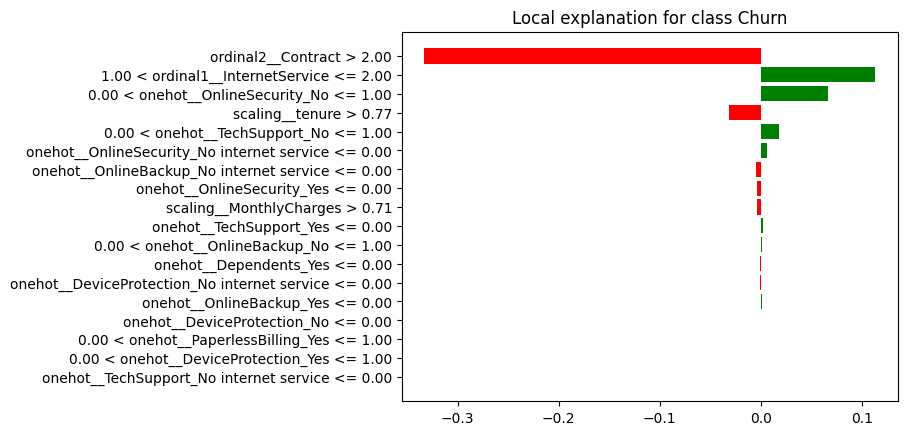

In [65]:
testnum = 2


print(f"The prediction must predict this customer is: {('churned' if y_test.iloc[testnum] == 1 else 'not churned')} from y_test")

exp = explainer_lime.explain_instance(data_row=X_test_transformed[testnum], 
                                 predict_fn = best_model_ada[2].predict_proba, 
                                 num_features=len(X_train_transformed))
exp.as_pyplot_figure();

As seen from the feature importances and the LIME, we could see that the most influential features for churning customers are contract, internet service, Online security, and tech support.


In [66]:
df_prob = X_train

df_prob['probability'] = best_model_ada.predict_proba(X_train)[:,1]

for i in ['Contract', 'InternetService', 'OnlineSecurity', 'TechSupport']:
    pivot = df_prob.groupby(by= i)['probability'].mean()
    print(pivot)


Contract
Month-to-month    0.659530
One year          0.298090
Two year          0.148638
Name: probability, dtype: float64
InternetService
DSL            0.396981
Fiber optic    0.594631
No             0.290654
Name: probability, dtype: float64
OnlineSecurity
No                     0.602805
No internet service    0.290654
Yes                    0.341812
Name: probability, dtype: float64
TechSupport
No                     0.598922
No internet service    0.290654
Yes                    0.349883
Name: probability, dtype: float64


****************

# **4. Conclusion & Recommendation**

## **4.1. Conclusion**

In [67]:
gridsearch_ada.best_estimator_

Pipeline(steps=[('resampling', RandomUnderSampler(random_state=0)),
                ('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Dependents',
                                                   'PaperlessBilling',
                                                   'OnlineSecurity',
                                                   'DeviceProtection',
                                                   'TechSupport',
                                                   'OnlineBackup']),
                                                 ('ordinal1',
                                                  Or...g=[{'col': 'InternetService',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': No             0
DSL            1
Fiber optic    2
dtype: int64}]),
                                                  ['InternetService']),
                                                 ('ordinal2',
                                                  OrdinalEncoder(mapping=[{'col': 'Contract',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': Month-to-month    1
One year          2
Two year          3
dtype: int64}]),
                                                  ['Contract'])])),
                ('modeling',
                 AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1,
                                    random_state=0))])

From the f2 scoring, we could see that the tuned AdaBoost algorithm is the best algorithm to create prediction of customer churn. The f2 score reached 0.761936.

The tuning done to the ADAboost algorithm is by using,
- Random Undersampler as its resampling of train data,
- algorithm used for the AdaBoost is 'SAMME',
- the learning rate for the AdaBoost is 0.1,
- The random state used is 0.
- The threshold is modified to 0.49.

Cost calculation:
- Without machine learning              = 258 x $784.60                 = $202,426.80
- with base AdaBoost machine learning   = 125 x $784.60 + 66 x $138.80  = $107,235.80
- With tuned AdaBoost machine learning  = 25 x $784.60 + 264 x $138.80  = $56,258.20

So, with the tuned machine learning, we could cut losses up to $146,168.60 or a percentage reduction of loss up to 72.21%


## **4.2. Recommendation**

### **4.2.1. For Future Analysis**
- For AdaBoost model, it is very sensitive to outliers, in the future, if the data have outliers, it will affect on its prediction capability. So, it might need a change of model in the future, or in the scaler in the transformer model such as using RobustScaler.
- Enhancing the model by including more data, especially on the minority class data, to make the model more accurate
- Add more features to the data analysis to create a more accurate model, such as customer satisfaction rate, or usage for voice, internet, or messages.

### **4.2.2. For Business**
From the Feature Importances and LIME:

- Contract -> Month-to-Month users tend to churn, we could create a promotion to convert them to long-term users such as using the 1-year or 2-year programme as they had lower probability to churn, or even reduce the probability in the LIME. This could apply to marketing team as they need to present the promotions for the MtM users.
    - In line with contract, longer tenure customers has lesser probability to churn, which supports why we need to create a strategy to convert customers into long-term users in the contracts.
- Internet Services -> Fiber Optic tend to has higher churn rate, this might due to low quality of the service, or the price is too high as can be seen from the EDA, we could upgrader our internet services or adjust our pricing rate to better match the market.
- Online Security -> no online security in our products lead to very high churn rate, we need to add more security in products so customers would trust our product more, leading to lower churn rate. We could create programmes that will have increased security so customers will not churn.
- Tech Support -> no tech support could lead to customers abandoning our products. We need to increase our customer support if there are problems. This also applies to the Customer Service Team.
- In the LIME, customers with online security and device protection still have higher probability to churn, meaning there is disatisfaction on the service provided by the company. This needs to be investigated further.

****************

# **5. Deployment**

In [68]:
import pickle
best_model_ada.fit(X,y)

pickle.dump(best_model_ada, open('model_adaboost_v1.sav', 'wb'))

**************